### SEGMENTACIÓN MEDIANTE THRESHOLDING

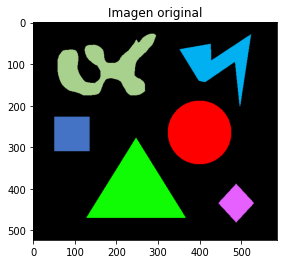

In [1]:
import matplotlib.pyplot as plt
import cv2

# Read an image
img = cv2.imread('images/figuras.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

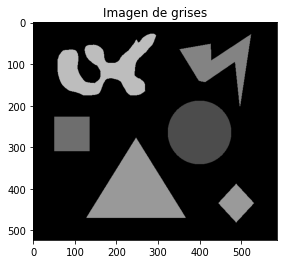

In [2]:
# Convertimos la imagen a escala de grises
import numpy as np
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray_img = cv2.imread('figuras.png', 0) # Una forma de leer la imagen directamente en escala de grises

plt.imshow(gray_img, cmap='gray')
plt.title('Imagen de grises')
plt.show()

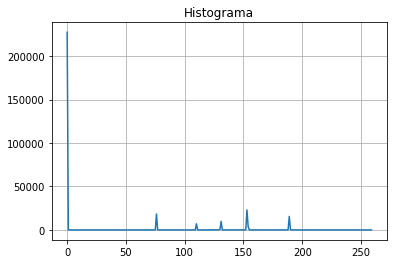

In [3]:
# Calculamos el histograma
hist = cv2.calcHist([gray_img], [0], None, [260], [0, 260]) # [0] son los canales, None la máscara

plt.plot(hist)
plt.grid()
plt.title('Histograma')
plt.show()

# Otra forma de mostrar el histograma (solo visualización)
# plt.hist(gray_img.ravel(), bins=50)
# plt.grid(True)
# plt.show()

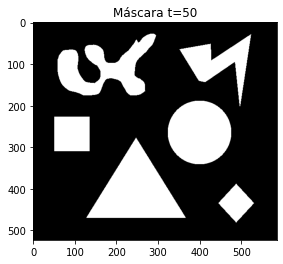

[  0 255]


In [4]:
# Fijamos el umbral en base al histograma anterior
t = 50

# Extreaemos la máscara binaria
maxim = 255
_, mask = cv2.threshold(gray_img, t, maxim, cv2.THRESH_BINARY)

# Otra formas de extraer la máscara 
# mask = gray_img.copy()
# mask = mask>t

# Visualizamos para corroborar
plt.imshow(mask, cmap='gray')
plt.title('Máscara t=' + str(t))
plt.show()

print(np.unique(mask)) # Atent@s a los formatos (bool, uint8, etc.)

[0 1]


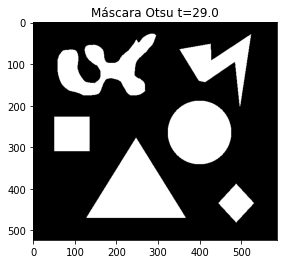

In [5]:
# Fijamos el umbral con el método de OTSU
t, mask = cv2.threshold(gray_img,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
print(np.unique(mask))

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

### SEGMENTACIÓN MEDIANTE CONVERSIONES DE COLOR

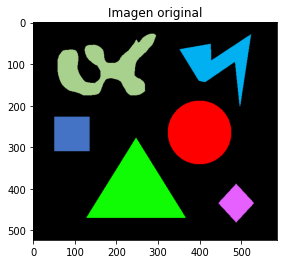

In [6]:
# Imaginamos que queremos segmentar únicamente el círculo
img = cv2.imread('images/figuras.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

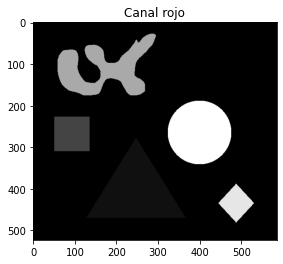

In [7]:
# Obtenemos el canal rojo
R = img[:,:,2]

plt.imshow(R, cmap='gray')
plt.title('Canal rojo')
plt.show()

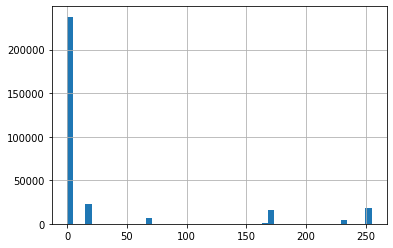

255


In [8]:
# Observamos el histograma
plt.hist(R.ravel(), bins=50)
plt.grid(True)
plt.show()
print(np.max(R))

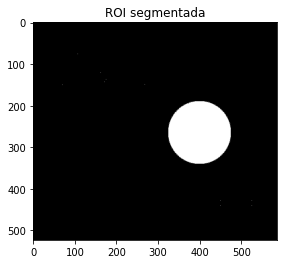

In [9]:
# Fijamos el umbral y extraemos la máscara
t=np.max(R)
mask = R.copy()
mask[mask<t] = 0

plt.imshow(mask, cmap='gray')
plt.title('ROI segmentada')
plt.show()

In [ ]:
# Ejercicio individual
# Obtener una máscara con la imagen del rayo azul mediante segmentación por espacio de color

# Función para extraer los colores secundarios
def convert_to_CMYK(rgb_p):
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(rgb_p, axis=2)
        C = (1-rgb_p[:,:,0] - K)/(1-K)
        M = (1-rgb_p[:,:,1] - K)/(1-K)
        Y = (1-rgb_p[:,:,2] - K)/(1-K)
    CMYK = (np.dstack((C,M,Y,K)))
    return CMYK

# Leer la imagen 
img = cv2.imread('images/figuras.png')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_p = rgb.astype('uint8')/255

# Extraer los colores secundarios
CMYK = ???

# Extraer los canales por separado
C,M,Y,K = ???
C = C.astype('uint8')

# Calcular la máscara de la figura del rayo
???

# Visualizar la máscara
plt.imshow(C, cmap='gray')
plt.title('ROI segmentada')
plt.show()

### SEGMENTACIÓN SEMÁNTICA CON DETECCIÓN DE BORDES

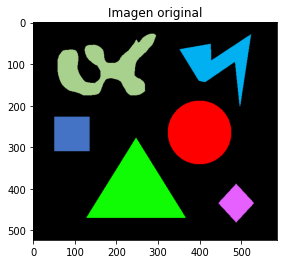

In [10]:
# SEGMENTACIÓN SEMÁNTICA CON DETECCIÓN DE BORDES
img = cv2.imread('images/figuras.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Imagen original')
plt.show()

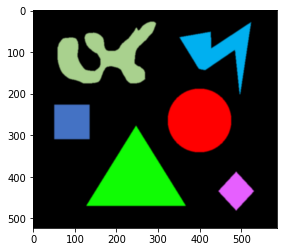

In [11]:
# Aplicamos un filtro gaussiano para emborronar las altas frecuencias
img_gaus = cv2.GaussianBlur(img_rgb, (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.imshow(img_gaus, cmap='gray')
plt.show()

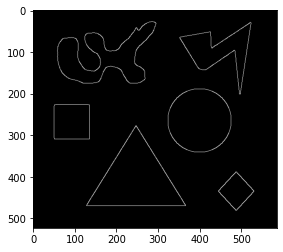

In [12]:
# Detección de bordes de Canny
canny = cv2.Canny(img_gaus, 255/3, 255) # minValue and maxValue. Canny recomienda que minValue sea 3 veces mayor que maxValue
kernel = np.ones((2,2), 'uint8')
#canny = cv2.dilate(canny, kernel, iterations=2)
#canny = cv2.erode(canny, kernel, iterations=2)

plt.imshow(canny, cmap='gray')
plt.show()

C:\Users\vicen\AppData\Local\Temp\ipykernel_11836\2220132281.py:2: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes as bfh


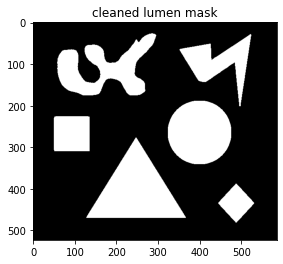

In [13]:
# Rellenar objetos (solo rellena si no están en contacto con el límite de la imagen)
from scipy.ndimage.morphology import binary_fill_holes as bfh
bordes = canny.copy()
filled_bordes = bfh(bordes)

plt.imshow(filled_bordes.astype('uint8'), cmap='gray')
plt.title('cleaned lumen mask')
plt.show()

### SEGMENTACIÓN POR CRECIMIENTO DE REGIONES (region growing)

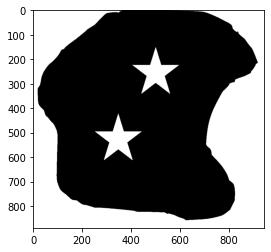

In [14]:
# Cargar imagen
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('images/estrellas.png', 0)

plt.imshow(img, cmap='gray')
plt.show()

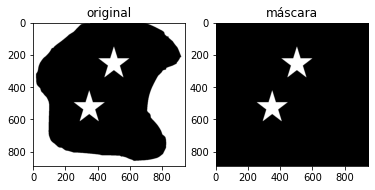

In [15]:
# Crear una copia de la imagen
mask = img.copy()

# Definir una imagen negra de referencia
h, w = img.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(mask, ref, (0,0), 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask, cmap='gray'), ax[1].set_title('máscara')
plt.show()